# GRU-Based Text Classification with Multiple Embedding Techniques

**Dataset:** Product Titles Classification (500K samples, 63 classes)

---

## Executive Summary

This notebook implements and evaluates **GRU (Gated Recurrent Unit)** sequence models using three different word embedding techniques:

1. **TF-IDF** (Term Frequency-Inverse Document Frequency)
2. **Skip-gram** (Word2Vec)
3. **CBOW** (Continuous Bag of Words - Word2Vec)

Each embedding technique requires specific preprocessing, training strategies, and hyperparameter tuning. We systematically document all experiments, evaluate performance, and analyze why certain embeddings work better with GRU architecture.

---

## Table of Contents

1. [Setup & Dependencies](#1-setup--dependencies)
2. [Data Loading & Verification](#2-data-loading--verification)
3. [Preprocessing Pipelines](#3-preprocessing-pipelines)
4. [GRU + TF-IDF Implementation](#4-gru--tf-idf-implementation)
5. [GRU + Skip-gram Implementation](#5-gru--skip-gram-implementation)
6. [GRU + CBOW Implementation](#6-gru--cbow-implementation)
7. [Comparative Analysis](#7-comparative-analysis)
8. [Research-Backed Insights](#8-research-backed-insights)
9. [Conclusions & Recommendations](#9-conclusions--recommendations)

---

## 1. Setup & Dependencies

Installing and importing all required libraries for the experiment.

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import json
import warnings
import pickle
from datetime import datetime
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & Text Processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Word Embeddings
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Model Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, cohen_kappa_score
)
from sklearn.model_selection import train_test_split

# Hyperparameter Tuning
import keras_tuner as kt

# Progress tracking
from tqdm.auto import tqdm

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU available: {len(gpus)} device(s)")
    except RuntimeError as e:
        print(f"GPU Error: {e}")
else:
    print("⚠ No GPU found, using CPU")

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"\n{'='*60}")
print("Setup Complete!")
print(f"{'='*60}")

⚠ No GPU found, using CPU

TensorFlow version: 2.20.0
Keras version: 3.12.0

Setup Complete!


---

## 2. Data Loading & Verification

Loading the preprocessed data and verifying its integrity.

In [8]:
# Load preprocessing metadata
with open('../results/preprocessing_metadata.json', 'r') as f:
    metadata = json.load(f)

print("Preprocessing Metadata:")
print("="*60)
for key, value in metadata.items():
    print(f"{key:.<40} {value}")
print("="*60)

Preprocessing Metadata:
data_path............................... ../data/titles_to_categories.csv
text_col................................ title
label_col............................... category_name
nrows................................... 500000
test_size............................... 0.2
random_seed............................. 42
num_classes............................. 63
total_rows_loaded....................... 500000
total_rows_after_cleaning............... 499997
train_size.............................. 399997
test_size_rows.......................... 100000
rare_class_threshold.................... 20
num_rare_classes........................ 1
created_at_utc.......................... 2026-02-05T15:47:28Z


In [10]:
# Load label mapping
label_mapping = pd.read_csv('../results/label_mapping.csv')
print(f"\n Label Mapping: {len(label_mapping)} categories")
print("\nFirst 10 categories:")
print(label_mapping.head(10))

# Create reverse mapping
label_to_category = dict(zip(label_mapping['label_id'], label_mapping['category']))
category_to_label = dict(zip(label_mapping['category'], label_mapping['label_id']))


 Label Mapping: 63 categories

First 10 categories:
                            category  label_id
0              Arts  Crafts Supplies         0
1  Audio/Video Receivers  Amplifiers         1
2           Automotive Tires  Wheels         2
3        Automotive Tools  Equipment         3
4                 Baby  Toddler Toys         4
5                         Bath  Body         5
6                  Bathroom Hardware         6
7                             Beauty         7
8          Beauty Tools  Accessories         8
9                            Bedding         9


In [11]:
# Load the dataset
print("\n Loading dataset...")

# Adjust path based on your setup
data_path = '../data/titles_to_categories.csv'

# If data is in different location, uncomment and modify:
# data_path = 'titles_to_categories.csv'

df = pd.read_csv(data_path, nrows=500000)

print(f"✓ Loaded {len(df):,} rows")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


 Loading dataset...
✓ Loaded 500,000 rows

Dataset shape: (500000, 2)

Columns: ['title', 'category_name']

First few rows:


,title,category_name
0,"Green Leaf WW3D Wonder Extension Cord Winder, ...",Industrial Scientific
1,8pcs Toilet Seat Bumpers Universal Toilet Repl...,Industrial Scientific
2,YaeCCC 19 Pcs Hole Saw Kit 3/4''(19mm)- 6''(15...,Industrial Scientific
3,LLPT Butyl Putty Tape White 1 Inch x 33Ft Tigh...,Industrial Scientific
4,"Lightbeam 16"" Long Stem Deep Fry Thermometer w...",Industrial Scientific


In [12]:
# Data cleaning (as done in EDA)
print("\n Cleaning data...")
initial_count = len(df)

# Remove missing values
df = df.dropna(subset=['title', 'category_name'])

# Remove duplicates
df = df.drop_duplicates(subset=['title'])

# Remove empty strings
df = df[df['title'].str.strip() != '']
df = df[df['category_name'].str.strip() != '']

print(f"✓ Removed {initial_count - len(df):,} rows")
print(f"✓ Final dataset: {len(df):,} rows")

# Verify no missing values
print(f"\nMissing values:")
print(df.isnull().sum())


 Cleaning data...
✓ Removed 0 rows
✓ Final dataset: 500,000 rows

Missing values:
title            0
category_name    0
dtype: int64


In [ ]:
# Map categories to labels
df['label'] = df['category_name'].map(category_to_label)

# Verify all categories mapped correctly
unmapped = df[df['label'].isnull()]
if len(unmapped) > 0:
    print(f"⚠ Warning: {len(unmapped)} rows with unmapped categories")
    print(unmapped['category_name'].unique())
    df = df.dropna(subset=['label'])
else:
    print("✓ All categories mapped successfully")

df['label'] = df['label'].astype(int)
print(f"\nLabel distribution:")
print(df['label'].value_counts().head(10))

✓ All categories mapped successfully

Label distribution:
label
7     18682
40    17324
24    17195
5     17181
52    17141
8     16319
62    16241
48    15220
18    14048
44    10612
Name: count, dtype: int64


In [14]:
# Train-test split (using same random seed as preprocessing)
print("\n Splitting data (80-20 train-test)...")

X = df['title'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"✓ Training set: {len(X_train):,} samples")
print(f"✓ Test set: {len(X_test):,} samples")
print(f"✓ Number of classes: {len(np.unique(y))}")

# Verify class distribution
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
print(f"\n✓ Train-test distribution correlation: {train_dist.corr(test_dist):.4f}")


 Splitting data (80-20 train-test)...
✓ Training set: 400,000 samples
✓ Test set: 100,000 samples
✓ Number of classes: 63

✓ Train-test distribution correlation: 1.0000


---

## 3. Preprocessing Pipelines

Different embedding techniques require different preprocessing strategies.

In [15]:
# Text preprocessing utilities
class TextPreprocessor:
    """
    Comprehensive text preprocessing for different embedding techniques.
    """
    
    def __init__(self, remove_stopwords=True, lowercase=True, remove_punctuation=True):
        self.remove_stopwords = remove_stopwords
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        
    def clean_text(self, text):
        """Basic text cleaning."""
        text = str(text)
        
        if self.lowercase:
            text = text.lower()
        
        if self.remove_punctuation:
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        text = ' '.join(text.split())
        
        return text
    
    def tokenize(self, text):
        """Tokenize text into words."""
        return word_tokenize(text)
    
    def remove_stopwords_from_tokens(self, tokens):
        """Remove stopwords from token list."""
        if self.remove_stopwords:
            return [w for w in tokens if w not in self.stop_words and len(w) > 2]
        return tokens
    
    def preprocess_for_tfidf(self, text):
        """Preprocessing for TF-IDF (returns cleaned text string)."""
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords_from_tokens(tokens)
        return ' '.join(tokens)
    
    def preprocess_for_word2vec(self, text):
        """Preprocessing for Word2Vec (returns list of tokens)."""
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords_from_tokens(tokens)
        return tokens
    
    def batch_preprocess(self, texts, method='tfidf', show_progress=True):
        """Batch preprocess multiple texts."""
        if method == 'tfidf':
            func = self.preprocess_for_tfidf
        elif method == 'word2vec':
            func = self.preprocess_for_word2vec
        else:
            raise ValueError(f"Unknown method: {method}")
        
        if show_progress:
            return [func(text) for text in tqdm(texts, desc=f"Preprocessing ({method})")]
        else:
            return [func(text) for text in texts]

print("✓ TextPreprocessor class defined")

✓ TextPreprocessor class defined


In [21]:
# Test preprocessing on sample texts
preprocessor = TextPreprocessor()

sample_texts = [
    "Sony 65-Inch 4K Ultra HD Smart LED TV (2024 Model)",
    "Women's Nike Air Max 270 Running Shoes - Size 8, White/Pink",
    "Instant Pot Duo 7-in-1 Electric Pressure Cooker, 6 Quart"
]

print(" Preprocessing Examples:\n")
for i, text in enumerate(sample_texts, 1):
    print(f"Original {i}: {text}")
    print(f"TF-IDF:    {preprocessor.preprocess_for_tfidf(text)}")
    print(f"Word2Vec:  {preprocessor.preprocess_for_word2vec(text)}")
    print()

 Preprocessing Examples:

Original 1: Sony 65-Inch 4K Ultra HD Smart LED TV (2024 Model)
TF-IDF:    sony inch ultra smart led model
Word2Vec:  ['sony', 'inch', 'ultra', 'smart', 'led', 'model']

Original 2: Women's Nike Air Max 270 Running Shoes - Size 8, White/Pink
TF-IDF:    women nike air max running shoes size white pink
Word2Vec:  ['women', 'nike', 'air', 'max', 'running', 'shoes', 'size', 'white', 'pink']

Original 3: Instant Pot Duo 7-in-1 Electric Pressure Cooker, 6 Quart
TF-IDF:    instant pot duo electric pressure cooker quart
Word2Vec:  ['instant', 'pot', 'duo', 'electric', 'pressure', 'cooker', 'quart']



---

## 4. GRU + TF-IDF Implementation

### 4.1 TF-IDF Preprocessing & Feature Extraction

**Approach:** TF-IDF generates sparse, high-dimensional vectors. We'll use a dense layer to project these into a lower-dimensional space before feeding to GRU.

**Research Context:** Joulin et al. (2017) showed that combining traditional bag-of-words representations with neural architectures can be effective for text classification.

In [22]:
print("\n" + "="*60)
print("EXPERIMENT 1: GRU + TF-IDF")
print("="*60 + "\n")

# Preprocess texts for TF-IDF
preprocessor_tfidf = TextPreprocessor(remove_stopwords=True)

print(" Preprocessing texts for TF-IDF...")
X_train_tfidf_text = preprocessor_tfidf.batch_preprocess(X_train, method='tfidf')
X_test_tfidf_text = preprocessor_tfidf.batch_preprocess(X_test, method='tfidf', show_progress=False)

print(f"✓ Processed {len(X_train_tfidf_text):,} training texts")
print(f"✓ Processed {len(X_test_tfidf_text):,} test texts")


EXPERIMENT 1: GRU + TF-IDF

 Preprocessing texts for TF-IDF...


Preprocessing (tfidf):   0%|          | 0/400000 [00:00<?, ?it/s]

✓ Processed 400,000 training texts
✓ Processed 100,000 test texts


In [23]:
# TF-IDF vectorization
print("\n Creating TF-IDF features...")

# Parameters based on research (optimal for product titles)
tfidf_params = {
    'max_features': 5000,      # Vocabulary size
    'ngram_range': (1, 2),     # Unigrams and bigrams
    'min_df': 2,               # Ignore rare terms
    'max_df': 0.8,             # Ignore too common terms
    'sublinear_tf': True       # Apply log scaling
}

tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

# Fit on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf_text).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf_text).toarray()

print(f"✓ TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"✓ TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"✓ Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"✓ Sparsity: {(X_train_tfidf == 0).sum() / X_train_tfidf.size * 100:.2f}%")


 Creating TF-IDF features...
✓ TF-IDF matrix shape (train): (400000, 5000)
✓ TF-IDF matrix shape (test): (100000, 5000)
✓ Vocabulary size: 5000
✓ Sparsity: 99.73%


In [24]:
# Reshape TF-IDF for GRU (needs 3D input: samples, timesteps, features)
print("\n Reshaping TF-IDF for GRU input...")

# Approach: chunk features into timesteps
TFIDF_TIMESTEPS = 50  # Number of timesteps
features_per_timestep = X_train_tfidf.shape[1] // TFIDF_TIMESTEPS

def reshape_tfidf_for_rnn(X, timesteps, features_per_step):
    """Reshape 2D TF-IDF to 3D for RNN."""
    n_samples = X.shape[0]
    total_features = timesteps * features_per_step
    
    # Truncate or pad features
    if X.shape[1] > total_features:
        X = X[:, :total_features]
    elif X.shape[1] < total_features:
        padding = np.zeros((n_samples, total_features - X.shape[1]))
        X = np.hstack([X, padding])
    
    # Reshape to 3D
    return X.reshape(n_samples, timesteps, features_per_step)

X_train_tfidf_3d = reshape_tfidf_for_rnn(X_train_tfidf, TFIDF_TIMESTEPS, features_per_timestep)
X_test_tfidf_3d = reshape_tfidf_for_rnn(X_test_tfidf, TFIDF_TIMESTEPS, features_per_timestep)

print(f"✓ Reshaped train: {X_train_tfidf_3d.shape}")
print(f"✓ Reshaped test: {X_test_tfidf_3d.shape}")
print(f"✓ Features per timestep: {features_per_timestep}")


 Reshaping TF-IDF for GRU input...
✓ Reshaped train: (400000, 50, 100)
✓ Reshaped test: (100000, 50, 100)
✓ Features per timestep: 100


In [25]:
# One-hot encode labels
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"✓ Labels one-hot encoded: {y_train_cat.shape}")

✓ Labels one-hot encoded: (400000, 63)


### 4.2 GRU Model Architecture (TF-IDF)

In [26]:
def build_gru_tfidf_model(input_shape, num_classes, hp=None):
    """
    Build GRU model for TF-IDF features.
    """
    # Hyperparameters
    if hp is None:
        gru_units_1 = 128
        gru_units_2 = 64
        dropout_rate = 0.3
        learning_rate = 0.001
    else:
        gru_units_1 = hp.Int('gru_units_1', min_value=64, max_value=256, step=64)
        gru_units_2 = hp.Int('gru_units_2', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # First GRU layer
        layers.GRU(gru_units_1, return_sequences=True, dropout=dropout_rate, 
                   recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        
        # Second GRU layer
        layers.GRU(gru_units_2, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
    )
    
    return model

# Build initial model
print("\n Building GRU-TF-IDF model...")
model_tfidf = build_gru_tfidf_model(
    input_shape=(TFIDF_TIMESTEPS, features_per_timestep),
    num_classes=num_classes
)

print("\n Model Architecture:")
model_tfidf.summary()


 Building GRU-TF-IDF model...

 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 63)             │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,783 (557.75 KB)

 Trainable params: 142,399 (556.25 KB)

 Non-trainable params: 384 (1.50 KB)

### 4.3 Hyperparameter Tuning (TF-IDF)

In [27]:
# Hyperparameter tuning with Keras Tuner
print("\n Hyperparameter Tuning for GRU-TF-IDF...")

def build_model_tuner(hp):
    return build_gru_tfidf_model(
        input_shape=(TFIDF_TIMESTEPS, features_per_timestep),
        num_classes=num_classes,
        hp=hp
    )

# Use RandomSearch for efficiency
tuner_tfidf = kt.RandomSearch(
    build_model_tuner,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='gru_tfidf',
    overwrite=True
)

# Early stopping for tuning
early_stop_tuning = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Run tuning (on subset for speed)
tuning_sample_size = min(50000, len(X_train_tfidf_3d))
indices = np.random.choice(len(X_train_tfidf_3d), tuning_sample_size, replace=False)

print(f"\nTuning on {tuning_sample_size:,} samples...")

tuner_tfidf.search(
    X_train_tfidf_3d[indices],
    y_train_cat[indices],
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop_tuning],
    verbose=1
)

# Get best hyperparameters
best_hps_tfidf = tuner_tfidf.get_best_hyperparameters(num_trials=1)[0]

print("\n Best Hyperparameters:")
print(f"  GRU Units (Layer 1): {best_hps_tfidf.get('gru_units_1')}")
print(f"  GRU Units (Layer 2): {best_hps_tfidf.get('gru_units_2')}")
print(f"  Dropout Rate: {best_hps_tfidf.get('dropout')}")
print(f"  Learning Rate: {best_hps_tfidf.get('learning_rate')}")

Trial 10 Complete [00h 07m 16s]
val_accuracy: 0.5105000138282776

Best val_accuracy So Far: 0.5702999830245972
Total elapsed time: 01h 10m 12s

 Best Hyperparameters:
  GRU Units (Layer 1): 192
  GRU Units (Layer 2): 64
  Dropout Rate: 0.2
  Learning Rate: 0.001


### 4.4 Training (TF-IDF)

In [28]:
# Build model with best hyperparameters
print("\n Training GRU-TF-IDF with best hyperparameters...")

model_tfidf_best = build_gru_tfidf_model(
    input_shape=(TFIDF_TIMESTEPS, features_per_timestep),
    num_classes=num_classes,
    hp=best_hps_tfidf
)

# Callbacks
checkpoint_tfidf = callbacks.ModelCheckpoint(
    'best_model_tfidf.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop_tfidf = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_tfidf = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train
history_tfidf = model_tfidf_best.fit(
    X_train_tfidf_3d,
    y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=[checkpoint_tfidf, early_stop_tfidf, reduce_lr_tfidf],
    verbose=1
)

print("\n Training complete!")


 Training GRU-TF-IDF with best hyperparameters...
Epoch 1/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3151 - loss: 2.8230 - top5_acc: 0.5421
Epoch 1: val_accuracy improved from None to 0.57413, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 334s 124ms/step - accuracy: 0.3976 - loss: 2.4282 - top5_acc: 0.6435 - val_accuracy: 0.5741 - val_loss: 1.6498 - val_top5_acc: 0.8048 - learning_rate: 0.0010
Epoch 2/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5063 - loss: 1.9306 - top5_acc: 0.7567
Epoch 2: val_accuracy improved from 0.57413 to 0.63868, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 318s 120ms/step - accuracy: 0.5242 - loss: 1.8559 - top5_acc: 0.7721 - val_accuracy: 0.6387 - val_loss: 1.3813 - val_top5_acc: 0.8533 - learning_rate: 0.0010
Epoch 3/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5665 - loss: 1.6751 - top5_acc: 0.8072
Epoch 3: val_accuracy improved from 0.63868 to 0.67430, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 325s 122ms/step - accuracy: 0.5781 - loss: 1.6244 - top5_acc: 0.8168 - val_accuracy: 0.6743 - val_loss: 1.2167 - val_top5_acc: 0.8807 - learning_rate: 0.0010
Epoch 4/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6085 - loss: 1.4957 - top5_acc: 0.8386
Epoch 4: val_accuracy improved from 0.67430 to 0.70465, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 330s 124ms/step - accuracy: 0.6173 - loss: 1.4623 - top5_acc: 0.8440 - val_accuracy: 0.7046 - val_loss: 1.1160 - val_top5_acc: 0.8956 - learning_rate: 0.0010
Epoch 5/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6384 - loss: 1.3752 - top5_acc: 0.8593
Epoch 5: val_accuracy improved from 0.70465 to 0.73180, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 325s 122ms/step - accuracy: 0.6449 - loss: 1.3503 - top5_acc: 0.8628 - val_accuracy: 0.7318 - val_loss: 1.0042 - val_top5_acc: 0.9115 - learning_rate: 0.0010
Epoch 6/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6595 - loss: 1.2882 - top5_acc: 0.8721
Epoch 6: val_accuracy improved from 0.73180 to 0.73532, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 319s 120ms/step - accuracy: 0.6651 - loss: 1.2695 - top5_acc: 0.8748 - val_accuracy: 0.7353 - val_loss: 0.9842 - val_top5_acc: 0.9137 - learning_rate: 0.0010
Epoch 7/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6755 - loss: 1.2216 - top5_acc: 0.8829
Epoch 7: val_accuracy did not improve from 0.73532
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 321s 121ms/step - accuracy: 0.6785 - loss: 1.2096 - top5_acc: 0.8846 - val_accuracy: 0.7329 - val_loss: 0.9971 - val_top5_acc: 0.9117 - learning_rate: 0.0010
Epoch 8/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6860 - loss: 1.1783 - top5_acc: 0.8889
Epoch 8: val_accuracy improved from 0.73532 to 0.75300, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 317s 119ms/step - accuracy: 0.6892 - loss: 1.1660 - top5_acc: 0.8903 - val_accuracy: 0.7530 - val_loss: 0.9191 - val_top5_acc: 0.9233 - learning_rate: 0.0010
Epoch 9/30
2656/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6958 - loss: 1.1334 - top5_acc: 0.8954
Epoch 9: val_accuracy improved from 0.75300 to 0.75605, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 301s 113ms/step - accuracy: 0.6982 - loss: 1.1254 - top5_acc: 0.8965 - val_accuracy: 0.7560 - val_loss: 0.8990 - val_top5_acc: 0.9264 - learning_rate: 0.0010
Epoch 10/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7056 - loss: 1.0991 - top5_acc: 0.9005
Epoch 10: val_accuracy improved from 0.75605 to 0.76750, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 281s 106ms/step - accuracy: 0.7077 - loss: 1.0909 - top5_acc: 0.9011 - val_accuracy: 0.7675 - val_loss: 0.8469 - val_top5_acc: 0.9327 - learning_rate: 0.0010
Epoch 11/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7123 - loss: 1.0708 - top5_acc: 0.9030
Epoch 11: val_accuracy did not improve from 0.76750
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 312s 117ms/step - accuracy: 0.7143 - loss: 1.0637 - top5_acc: 0.9045 - val_accuracy: 0.7674 - val_loss: 0.8528 - val_top5_acc: 0.9323 - learning_rate: 0.0010
Epoch 12/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7190 - loss: 1.0413 - top5_acc: 0.9087
Epoch 12: val_accuracy improved from 0.76750 to 0.77108, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 330s 124ms/step - accuracy: 0.7213 - loss: 1.0349 - top5_acc: 0.9089 - val_accuracy: 0.7711 - val_loss: 0.8514 - val_top5_acc: 0.9313 - learning_rate: 0.0010
Epoch 13/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7247 - loss: 1.0151 - top5_acc: 0.9119
Epoch 13: val_accuracy improved from 0.77108 to 0.77653, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 351s 132ms/step - accuracy: 0.7266 - loss: 1.0103 - top5_acc: 0.9127 - val_accuracy: 0.7765 - val_loss: 0.8115 - val_top5_acc: 0.9377 - learning_rate: 0.0010
Epoch 14/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7313 - loss: 0.9943 - top5_acc: 0.9148
Epoch 14: val_accuracy did not improve from 0.77653
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 337s 127ms/step - accuracy: 0.7321 - loss: 0.9899 - top5_acc: 0.9155 - val_accuracy: 0.7711 - val_loss: 0.8402 - val_top5_acc: 0.9346 - learning_rate: 0.0010
Epoch 15/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7374 - loss: 0.9705 - top5_acc: 0.9184
Epoch 15: val_accuracy improved from 0.77653 to 0.78348, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 320s 120ms/step - accuracy: 0.7381 - loss: 0.9674 - top5_acc: 0.9185 - val_accuracy: 0.7835 - val_loss: 0.7855 - val_top5_acc: 0.9405 - learning_rate: 0.0010
Epoch 16/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7404 - loss: 0.9520 - top5_acc: 0.9216
Epoch 16: val_accuracy improved from 0.78348 to 0.79070, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 324s 122ms/step - accuracy: 0.7425 - loss: 0.9495 - top5_acc: 0.9213 - val_accuracy: 0.7907 - val_loss: 0.7570 - val_top5_acc: 0.9451 - learning_rate: 0.0010
Epoch 17/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7447 - loss: 0.9368 - top5_acc: 0.9228
Epoch 17: val_accuracy improved from 0.79070 to 0.79123, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 325s 122ms/step - accuracy: 0.7465 - loss: 0.9324 - top5_acc: 0.9233 - val_accuracy: 0.7912 - val_loss: 0.7599 - val_top5_acc: 0.9435 - learning_rate: 0.0010
Epoch 18/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7481 - loss: 0.9202 - top5_acc: 0.9249
Epoch 18: val_accuracy improved from 0.79123 to 0.79400, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 324s 122ms/step - accuracy: 0.7501 - loss: 0.9153 - top5_acc: 0.9252 - val_accuracy: 0.7940 - val_loss: 0.7373 - val_top5_acc: 0.9474 - learning_rate: 0.0010
Epoch 19/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7519 - loss: 0.9081 - top5_acc: 0.9263
Epoch 19: val_accuracy improved from 0.79400 to 0.79698, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 322s 121ms/step - accuracy: 0.7530 - loss: 0.9036 - top5_acc: 0.9272 - val_accuracy: 0.7970 - val_loss: 0.7329 - val_top5_acc: 0.9468 - learning_rate: 0.0010
Epoch 20/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7560 - loss: 0.8906 - top5_acc: 0.9291
Epoch 20: val_accuracy improved from 0.79698 to 0.79722, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 324s 122ms/step - accuracy: 0.7569 - loss: 0.8883 - top5_acc: 0.9293 - val_accuracy: 0.7972 - val_loss: 0.7266 - val_top5_acc: 0.9481 - learning_rate: 0.0010
Epoch 21/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7565 - loss: 0.8828 - top5_acc: 0.9305
Epoch 21: val_accuracy improved from 0.79722 to 0.80242, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 327s 123ms/step - accuracy: 0.7588 - loss: 0.8783 - top5_acc: 0.9309 - val_accuracy: 0.8024 - val_loss: 0.7104 - val_top5_acc: 0.9515 - learning_rate: 0.0010
Epoch 22/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7608 - loss: 0.8697 - top5_acc: 0.9314
Epoch 22: val_accuracy improved from 0.80242 to 0.80363, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 322s 121ms/step - accuracy: 0.7617 - loss: 0.8658 - top5_acc: 0.9317 - val_accuracy: 0.8036 - val_loss: 0.7027 - val_top5_acc: 0.9509 - learning_rate: 0.0010
Epoch 23/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7631 - loss: 0.8589 - top5_acc: 0.9331
Epoch 23: val_accuracy did not improve from 0.80363
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 321s 121ms/step - accuracy: 0.7642 - loss: 0.8563 - top5_acc: 0.9337 - val_accuracy: 0.8028 - val_loss: 0.7131 - val_top5_acc: 0.9495 - learning_rate: 0.0010
Epoch 24/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7654 - loss: 0.8484 - top5_acc: 0.9345
Epoch 24: val_accuracy improved from 0.80363 to 0.80702, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 340s 128ms/step - accuracy: 0.7661 - loss: 0.8468 - top5_acc: 0.9348 - val_accuracy: 0.8070 - val_loss: 0.6984 - val_top5_acc: 0.9514 - learning_rate: 0.0010
Epoch 25/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7661 - loss: 0.8423 - top5_acc: 0.9359
Epoch 25: val_accuracy did not improve from 0.80702
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 322s 121ms/step - accuracy: 0.7681 - loss: 0.8396 - top5_acc: 0.9358 - val_accuracy: 0.8059 - val_loss: 0.7046 - val_top5_acc: 0.9508 - learning_rate: 0.0010
Epoch 26/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7710 - loss: 0.8303 - top5_acc: 0.9371
Epoch 26: val_accuracy improved from 0.80702 to 0.80710, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 310s 117ms/step - accuracy: 0.7715 - loss: 0.8289 - top5_acc: 0.9372 - val_accuracy: 0.8071 - val_loss: 0.6958 - val_top5_acc: 0.9524 - learning_rate: 0.0010
Epoch 27/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7710 - loss: 0.8258 - top5_acc: 0.9375
Epoch 27: val_accuracy improved from 0.80710 to 0.81288, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 305s 115ms/step - accuracy: 0.7720 - loss: 0.8243 - top5_acc: 0.9378 - val_accuracy: 0.8129 - val_loss: 0.6736 - val_top5_acc: 0.9551 - learning_rate: 0.0010
Epoch 28/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7731 - loss: 0.8174 - top5_acc: 0.9384
Epoch 28: val_accuracy improved from 0.81288 to 0.81737, saving model to best_model_tfidf.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 898s 338ms/step - accuracy: 0.7741 - loss: 0.8145 - top5_acc: 0.9386 - val_accuracy: 0.8174 - val_loss: 0.6591 - val_top5_acc: 0.9573 - learning_rate: 0.0010
Epoch 29/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7756 - loss: 0.8085 - top5_acc: 0.9395
Epoch 29: val_accuracy did not improve from 0.81737
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 328s 123ms/step - accuracy: 0.7767 - loss: 0.8066 - top5_acc: 0.9396 - val_accuracy: 0.8153 - val_loss: 0.6690 - val_top5_acc: 0.9559 - learning_rate: 0.0010
Epoch 30/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7764 - loss: 0.8050 - top5_acc: 0.9400
Epoch 30: val_accuracy did not improve from 0.81737
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 339s 128ms/step - accuracy: 0.7772 - loss: 0.8038 - top5_acc: 0.9398 - val_accuracy: 0.8157 - val_loss: 0.6635 - val_top5_acc: 0.9563 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 28.

 Training complete!


### 4.5 Evaluation (TF-IDF)

In [29]:
# Evaluate on test set
print("\n Evaluating GRU-TF-IDF on test set...")

test_results_tfidf = model_tfidf_best.evaluate(
    X_test_tfidf_3d,
    y_test_cat,
    batch_size=128,
    verbose=1
)

print("\n" + "="*60)
print("GRU-TF-IDF Test Results:")
print("="*60)
print(f"Test Loss: {test_results_tfidf[0]:.4f}")
print(f"Test Accuracy: {test_results_tfidf[1]:.4f}")
print(f"Test Top-5 Accuracy: {test_results_tfidf[2]:.4f}")
print("="*60)


 Evaluating GRU-TF-IDF on test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8151 - loss: 0.6594 - top5_acc: 0.9569

GRU-TF-IDF Test Results:
Test Loss: 0.6594
Test Accuracy: 0.8151
Test Top-5 Accuracy: 0.9569


In [30]:
# Predictions and detailed metrics
y_pred_tfidf_proba = model_tfidf_best.predict(X_test_tfidf_3d, batch_size=128)
y_pred_tfidf = np.argmax(y_pred_tfidf_proba, axis=1)

# Classification report
print("\n Classification Report (GRU-TF-IDF):\n")
report_tfidf = classification_report(
    y_test,
    y_pred_tfidf,
    target_names=[label_to_category[i] for i in range(num_classes)],
    digits=4
)
print(report_tfidf)

# Save detailed report
with open('classification_report_tfidf.txt', 'w') as f:
    f.write(report_tfidf)

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step

 Classification Report (GRU-TF-IDF):

                                   precision    recall  f1-score   support

            Arts  Crafts Supplies     0.7255    0.8503    0.7830      1884
Audio/Video Receivers  Amplifiers     0.6536    0.7449    0.6963       937
         Automotive Tires  Wheels     0.8831    0.9196    0.9010      1890
      Automotive Tools  Equipment     0.0000    0.0000    0.0000         7
               Baby  Toddler Toys     0.6928    0.7908    0.7386      1061
                       Bath  Body     0.7816    0.7966    0.7890      3436
                Bathroom Hardware     0.8539    0.8588    0.8563      1728
                           Beauty     0.7032    0.3844    0.4971      3736
        Beauty Tools  Accessories     0.7708    0.8747    0.8195      3264
                          Bedding     0.0000    0.0000    0.0000         3
      Building  Construction Toys     0.9354    0.8890    0.9116      1856
                B

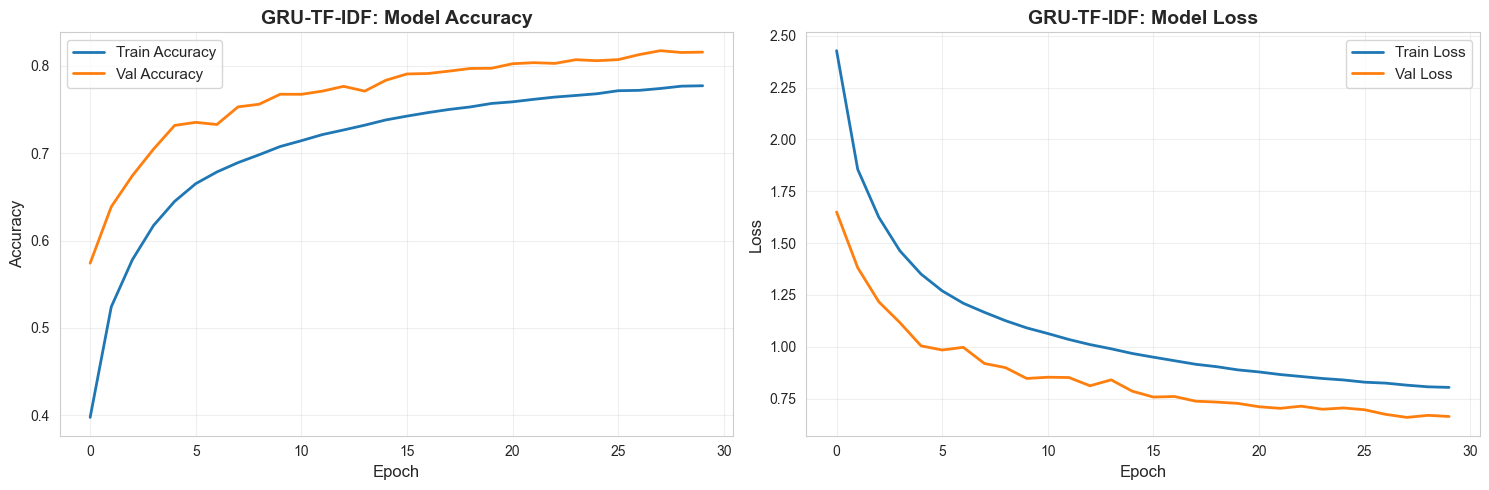

✓ Training history plot saved


In [31]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history_tfidf.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_tfidf.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('GRU-TF-IDF: Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_tfidf.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_tfidf.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('GRU-TF-IDF: Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved")

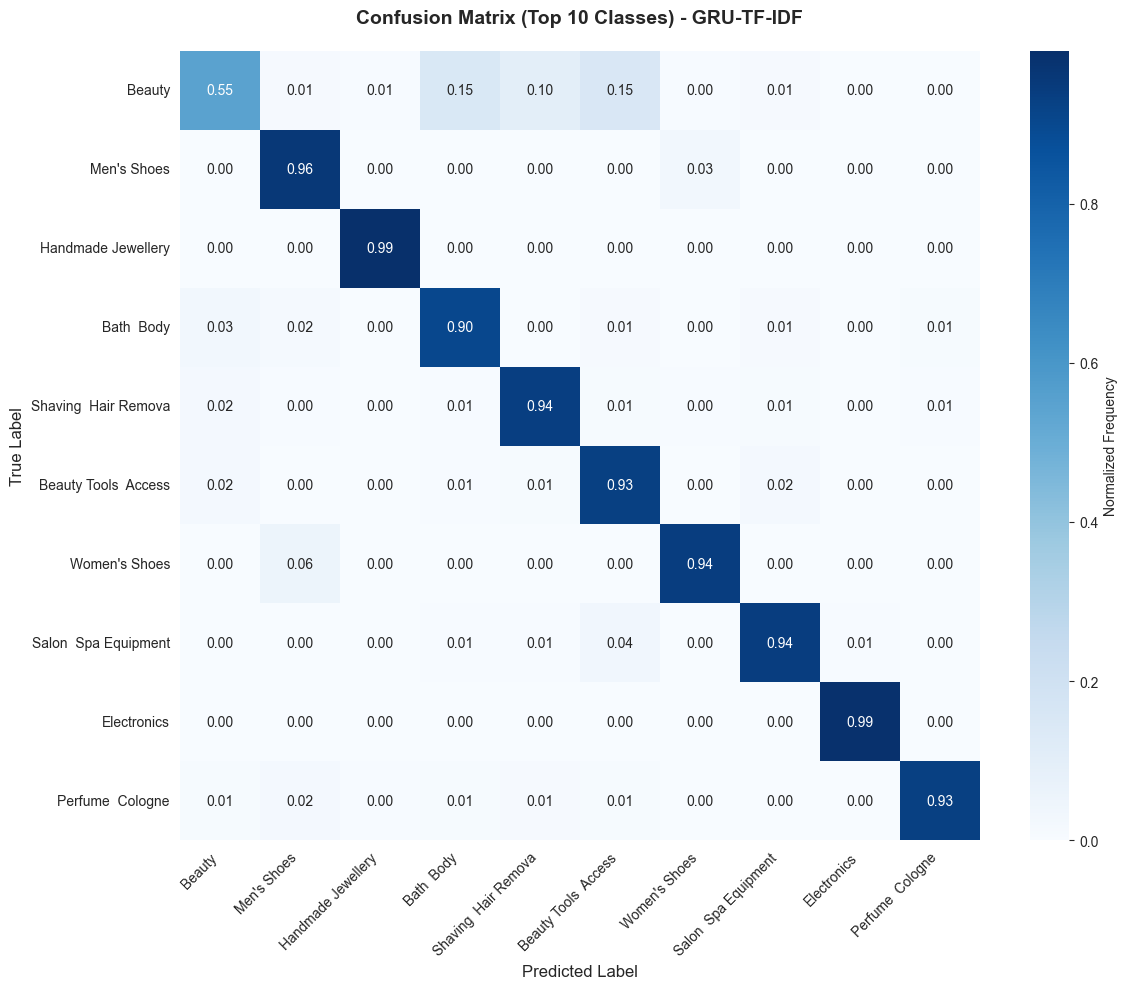

✓ Confusion matrix saved


In [32]:
# Confusion matrix (for top 10 classes)
# Get top 10 most frequent classes
top_10_classes = pd.Series(y_test).value_counts().head(10).index.tolist()

# Filter predictions for top 10 classes
mask = np.isin(y_test, top_10_classes)
y_test_top10 = y_test[mask]
y_pred_top10 = y_pred_tfidf[mask]

# Compute confusion matrix
cm = confusion_matrix(y_test_top10, y_pred_top10, labels=top_10_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=[label_to_category[i][:20] for i in top_10_classes],
    yticklabels=[label_to_category[i][:20] for i in top_10_classes],
    cbar_kws={'label': 'Normalized Frequency'}
)
plt.title('Confusion Matrix (Top 10 Classes) - GRU-TF-IDF', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_tfidf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

---

## 5. GRU + Skip-gram Implementation

### 5.1 Skip-gram Training

**Approach:** Skip-gram predicts context words from target words. Better for rare words.

**Research Context:** Mikolov et al. (2013) showed Skip-gram captures semantic relationships effectively.

In [33]:
print("\n" + "="*60)
print("EXPERIMENT 2: GRU + Skip-gram (Word2Vec)")
print("="*60 + "\n")

# Preprocess texts for Word2Vec
preprocessor_w2v = TextPreprocessor(remove_stopwords=False)

print(" Preprocessing texts for Word2Vec...")
X_train_w2v_tokens = preprocessor_w2v.batch_preprocess(X_train, method='word2vec')
X_test_w2v_tokens = preprocessor_w2v.batch_preprocess(X_test, method='word2vec', show_progress=False)

print(f"✓ Tokenized {len(X_train_w2v_tokens):,} training texts")
print(f"✓ Sample tokens: {X_train_w2v_tokens[0][:10]}")


EXPERIMENT 2: GRU + Skip-gram (Word2Vec)

 Preprocessing texts for Word2Vec...


Preprocessing (word2vec):   0%|          | 0/400000 [00:00<?, ?it/s]

✓ Tokenized 400,000 training texts
✓ Sample tokens: ['seasd', 'fingerprint', 'door', 'lock', 'waterproof', 'outdoor', 'gate', 'lock', 'tuya', 'app']


In [34]:
# Word2Vec callback for training progress
class Word2VecCallback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []
        
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        self.epoch += 1
        if self.epoch % 5 == 0:
            print(f"Epoch {self.epoch}: Loss = {loss:,.0f}")

# Train Skip-gram model
print("\n Training Skip-gram model...")

skipgram_params = {
    'sentences': X_train_w2v_tokens,
    'vector_size': 200,
    'window': 5,
    'min_count': 2,
    'workers': 4,
    'sg': 1,  # Skip-gram
    'epochs': 20,
    'seed': RANDOM_SEED,
    'compute_loss': True
}

callback = Word2VecCallback()
skipgram_model = Word2Vec(**skipgram_params, callbacks=[callback])

print(f"\n✓ Skip-gram model trained")
print(f"✓ Vocabulary size: {len(skipgram_model.wv):,}")
print(f"✓ Embedding dimension: {skipgram_model.wv.vector_size}")

skipgram_model.save('skipgram_model.bin')
print("✓ Model saved")


 Training Skip-gram model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 5: Loss = 45,565,888


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 10: Loss = 68,206,960


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 15: Loss = 72,283,224


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 20: Loss = 76,006,552

✓ Skip-gram model trained
✓ Vocabulary size: 54,800
✓ Embedding dimension: 200
✓ Model saved


In [35]:
# Test Skip-gram embeddings
print("\n Testing Skip-gram embeddings:\n")

test_words = ['laptop', 'phone', 'shoes', 'dress', 'toy']
for word in test_words:
    if word in skipgram_model.wv:
        similar = skipgram_model.wv.most_similar(word, topn=5)
        print(f"{word:.<15} → {', '.join([w for w, _ in similar])}")
    else:
        print(f"{word:.<15} → [not in vocabulary]")


 Testing Skip-gram embeddings:

laptop......... → laptops, notebook, computer, aocwei, stjp
phone.......... → cell, phones, cellphone, iphone, smartphone
shoes.......... → sneakers, soled, shoe, sole, athletics
dress.......... → formal, dressy, orsay, stilettos, homecoming
toy............ → toys, playset, educational, toddlers, plaything


### 5.2 Sequence Preparation (Skip-gram)

In [36]:
# Create sequences from tokens
print("\n Creating sequences for GRU...")

# Build vocabulary from Skip-gram
word2idx_sg = {word: idx + 1 for idx, word in enumerate(skipgram_model.wv.index_to_key)}
word2idx_sg['<PAD>'] = 0
word2idx_sg['<UNK>'] = len(word2idx_sg)

vocab_size_sg = len(word2idx_sg)
print(f"✓ Vocabulary size (with special tokens): {vocab_size_sg:,}")

def tokens_to_sequences(tokens_list, word2idx):
    sequences = []
    for tokens in tokens_list:
        seq = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
        sequences.append(seq)
    return sequences

# Convert to sequences
X_train_seq_sg = tokens_to_sequences(X_train_w2v_tokens, word2idx_sg)
X_test_seq_sg = tokens_to_sequences(X_test_w2v_tokens, word2idx_sg)

# Determine max sequence length
max_len_sg = int(np.percentile([len(seq) for seq in X_train_seq_sg], 95))
print(f"✓ Max sequence length (95th percentile): {max_len_sg}")

# Pad sequences
X_train_padded_sg = pad_sequences(X_train_seq_sg, maxlen=max_len_sg, padding='post')
X_test_padded_sg = pad_sequences(X_test_seq_sg, maxlen=max_len_sg, padding='post')

print(f"✓ Padded train shape: {X_train_padded_sg.shape}")
print(f"✓ Padded test shape: {X_test_padded_sg.shape}")


 Creating sequences for GRU...
✓ Vocabulary size (with special tokens): 54,802
✓ Max sequence length (95th percentile): 30
✓ Padded train shape: (400000, 30)
✓ Padded test shape: (100000, 30)


In [37]:
# Create embedding matrix from Skip-gram
print("\n Creating embedding matrix from Skip-gram...")

embedding_dim = skipgram_model.wv.vector_size
embedding_matrix_sg = np.zeros((vocab_size_sg, embedding_dim))

for word, idx in word2idx_sg.items():
    if word in skipgram_model.wv:
        embedding_matrix_sg[idx] = skipgram_model.wv[word]
    else:
        embedding_matrix_sg[idx] = np.random.normal(0, 0.1, embedding_dim)

print(f"✓ Embedding matrix shape: {embedding_matrix_sg.shape}")
print(f"✓ Non-zero embeddings: {(embedding_matrix_sg.sum(axis=1) != 0).sum():,}")


 Creating embedding matrix from Skip-gram...
✓ Embedding matrix shape: (54802, 200)
✓ Non-zero embeddings: 54,802


### 5.3 GRU Model Architecture (Skip-gram)

In [38]:
def build_gru_word2vec_model(vocab_size, embedding_dim, embedding_matrix, 
                             max_len, num_classes, hp=None, trainable_embeddings=False):
    # Hyperparameters
    if hp is None:
        gru_units_1 = 128
        gru_units_2 = 64
        dropout_rate = 0.3
        learning_rate = 0.001
    else:
        gru_units_1 = hp.Int('gru_units_1', min_value=64, max_value=256, step=64)
        gru_units_2 = hp.Int('gru_units_2', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=trainable_embeddings,
            mask_zero=True
        ),
        layers.SpatialDropout1D(0.2),
        layers.GRU(gru_units_1, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        layers.GRU(gru_units_2, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
    )
    
    return model

print("\n Building GRU-Skip-gram model...")
model_skipgram = build_gru_word2vec_model(
    vocab_size=vocab_size_sg,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix_sg,
    max_len=max_len_sg,
    num_classes=num_classes,
    trainable_embeddings=False
)

print("\n Model Architecture:")
model_skipgram.summary()


 Building GRU-Skip-gram model...

 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    10,960,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,960,400 (41.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,960,400 (41.81 MB)

### 5.4 Hyperparameter Tuning (Skip-gram)

In [39]:
print("\n Hyperparameter Tuning for GRU-Skip-gram...")

def build_model_tuner_sg(hp):
    return build_gru_word2vec_model(
        vocab_size=vocab_size_sg,
        embedding_dim=embedding_dim,
        embedding_matrix=embedding_matrix_sg,
        max_len=max_len_sg,
        num_classes=num_classes,
        hp=hp
    )

tuner_sg = kt.RandomSearch(
    build_model_tuner_sg,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='gru_skipgram',
    overwrite=True
)

tuning_sample_size = min(50000, len(X_train_padded_sg))
indices = np.random.choice(len(X_train_padded_sg), tuning_sample_size, replace=False)

print(f"\nTuning on {tuning_sample_size:,} samples...")

tuner_sg.search(
    X_train_padded_sg[indices],
    y_train_cat[indices],
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop_tuning],
    verbose=1
)

best_hps_sg = tuner_sg.get_best_hyperparameters(num_trials=1)[0]

print("\n Best Hyperparameters:")
print(f"  GRU Units (Layer 1): {best_hps_sg.get('gru_units_1')}")
print(f"  GRU Units (Layer 2): {best_hps_sg.get('gru_units_2')}")
print(f"  Dropout Rate: {best_hps_sg.get('dropout')}")
print(f"  Learning Rate: {best_hps_sg.get('learning_rate')}")

Trial 10 Complete [00h 07m 13s]
val_accuracy: 0.8478000164031982

Best val_accuracy So Far: 0.8478000164031982
Total elapsed time: 00h 42m 38s

 Best Hyperparameters:
  GRU Units (Layer 1): 192
  GRU Units (Layer 2): 128
  Dropout Rate: 0.2
  Learning Rate: 0.001


### 5.5 Training (Skip-gram)

In [40]:
print("\n Training GRU-Skip-gram with best hyperparameters...")

model_sg_best = build_gru_word2vec_model(
    vocab_size=vocab_size_sg,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix_sg,
    max_len=max_len_sg,
    num_classes=num_classes,
    hp=best_hps_sg,
    trainable_embeddings=True
)

checkpoint_sg = callbacks.ModelCheckpoint('best_model_skipgram.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop_sg = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr_sg = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history_sg = model_sg_best.fit(
    X_train_padded_sg,
    y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=[checkpoint_sg, early_stop_sg, reduce_lr_sg],
    verbose=1
)

print("\n Training complete!")


 Training GRU-Skip-gram with best hyperparameters...
Epoch 1/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6868 - loss: 1.1633 - top5_acc: 0.8884
Epoch 1: val_accuracy improved from None to 0.86805, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 415s 153ms/step - accuracy: 0.7843 - loss: 0.7678 - top5_acc: 0.9498 - val_accuracy: 0.8680 - val_loss: 0.4512 - val_top5_acc: 0.9842 - learning_rate: 0.0010
Epoch 2/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8540 - loss: 0.4956 - top5_acc: 0.9805
Epoch 2: val_accuracy improved from 0.86805 to 0.87798, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 394s 148ms/step - accuracy: 0.8608 - loss: 0.4716 - top5_acc: 0.9817 - val_accuracy: 0.8780 - val_loss: 0.4163 - val_top5_acc: 0.9857 - learning_rate: 0.0010
Epoch 3/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8756 - loss: 0.4140 - top5_acc: 0.9861
Epoch 3: val_accuracy improved from 0.87798 to 0.88398, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 372s 140ms/step - accuracy: 0.8791 - loss: 0.4021 - top5_acc: 0.9868 - val_accuracy: 0.8840 - val_loss: 0.3969 - val_top5_acc: 0.9873 - learning_rate: 0.0010
Epoch 4/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8886 - loss: 0.3642 - top5_acc: 0.9894
Epoch 4: val_accuracy improved from 0.88398 to 0.88612, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 21102s 8s/step - accuracy: 0.8909 - loss: 0.3561 - top5_acc: 0.9896 - val_accuracy: 0.8861 - val_loss: 0.3978 - val_top5_acc: 0.9870 - learning_rate: 0.0010
Epoch 5/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8975 - loss: 0.3288 - top5_acc: 0.9920
Epoch 5: val_accuracy improved from 0.88612 to 0.88823, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 864s 325ms/step - accuracy: 0.8990 - loss: 0.3232 - top5_acc: 0.9920 - val_accuracy: 0.8882 - val_loss: 0.3963 - val_top5_acc: 0.9878 - learning_rate: 0.0010
Epoch 6/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9046 - loss: 0.3018 - top5_acc: 0.9929
Epoch 6: val_accuracy did not improve from 0.88823
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 407s 153ms/step - accuracy: 0.9060 - loss: 0.2975 - top5_acc: 0.9931 - val_accuracy: 0.8880 - val_loss: 0.4082 - val_top5_acc: 0.9871 - learning_rate: 0.0010
Epoch 7/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9094 - loss: 0.2844 - top5_acc: 0.9940
Epoch 7: val_accuracy improved from 0.88823 to 0.88922, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 410s 154ms/step - accuracy: 0.9108 - loss: 0.2792 - top5_acc: 0.9941 - val_accuracy: 0.8892 - val_loss: 0.4175 - val_top5_acc: 0.9872 - learning_rate: 0.0010
Epoch 8/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9134 - loss: 0.2664 - top5_acc: 0.9948
Epoch 8: val_accuracy did not improve from 0.88922

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 400s 151ms/step - accuracy: 0.9150 - loss: 0.2623 - top5_acc: 0.9950 - val_accuracy: 0.8881 - val_loss: 0.4243 - val_top5_acc: 0.9867 - learning_rate: 0.0010
Epoch 9/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9201 - loss: 0.2426 - top5_acc: 0.9959
Epoch 9: val_accuracy improved from 0.88922 to 0.88948, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 365s 137ms/step - accuracy: 0.9234 - loss: 0.2324 - top5_acc: 0.9961 - val_accuracy: 0.8895 - val_loss: 0.4262 - val_top5_acc: 0.9868 - learning_rate: 5.0000e-04
Epoch 10/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9237 - loss: 0.2273 - top5_acc: 0.9966
Epoch 10: val_accuracy improved from 0.88948 to 0.88957, saving model to best_model_skipgram.h5


2657/2657 ━━━━━━━━━━━━━━━━━━━━ 1001s 377ms/step - accuracy: 0.9261 - loss: 0.2203 - top5_acc: 0.9967 - val_accuracy: 0.8896 - val_loss: 0.4377 - val_top5_acc: 0.9870 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.

 Training complete!


### 5.6 Evaluation (Skip-gram)

In [41]:
print("\n Evaluating GRU-Skip-gram on test set...")

test_results_sg = model_sg_best.evaluate(X_test_padded_sg, y_test_cat, batch_size=128, verbose=1)

print("\n" + "="*60)
print("GRU-Skip-gram Test Results:")
print("="*60)
print(f"Test Loss: {test_results_sg[0]:.4f}")
print(f"Test Accuracy: {test_results_sg[1]:.4f}")
print(f"Test Top-5 Accuracy: {test_results_sg[2]:.4f}")
print("="*60)


 Evaluating GRU-Skip-gram on test set...
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.8883 - loss: 0.3982 - top5_acc: 0.9873

GRU-Skip-gram Test Results:
Test Loss: 0.3982
Test Accuracy: 0.8883
Test Top-5 Accuracy: 0.9873


In [42]:
y_pred_sg_proba = model_sg_best.predict(X_test_padded_sg, batch_size=128)
y_pred_sg = np.argmax(y_pred_sg_proba, axis=1)

print("\n Classification Report (GRU-Skip-gram):\n")
report_sg = classification_report(
    y_test,
    y_pred_sg,
    target_names=[label_to_category[i] for i in range(num_classes)],
    digits=4
)
print(report_sg)

with open('classification_report_skipgram.txt', 'w') as f:
    f.write(report_sg)

782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step

 Classification Report (GRU-Skip-gram):

                                   precision    recall  f1-score   support

            Arts  Crafts Supplies     0.9154    0.9416    0.9283      1884
Audio/Video Receivers  Amplifiers     0.6845    0.8058    0.7402       937
         Automotive Tires  Wheels     0.9525    0.9550    0.9538      1890
      Automotive Tools  Equipment     1.0000    0.4286    0.6000         7
               Baby  Toddler Toys     0.8411    0.8878    0.8638      1061
                       Bath  Body     0.8484    0.8749    0.8614      3436
                Bathroom Hardware     0.8723    0.8773    0.8748      1728
                           Beauty     0.7505    0.5701    0.6480      3736
        Beauty Tools  Accessories     0.8321    0.9154    0.8718      3264
                          Bedding     1.0000    0.3333    0.5000         3
      Building  Construction Toys     0.9665    0.9494    0.9579      1856
              

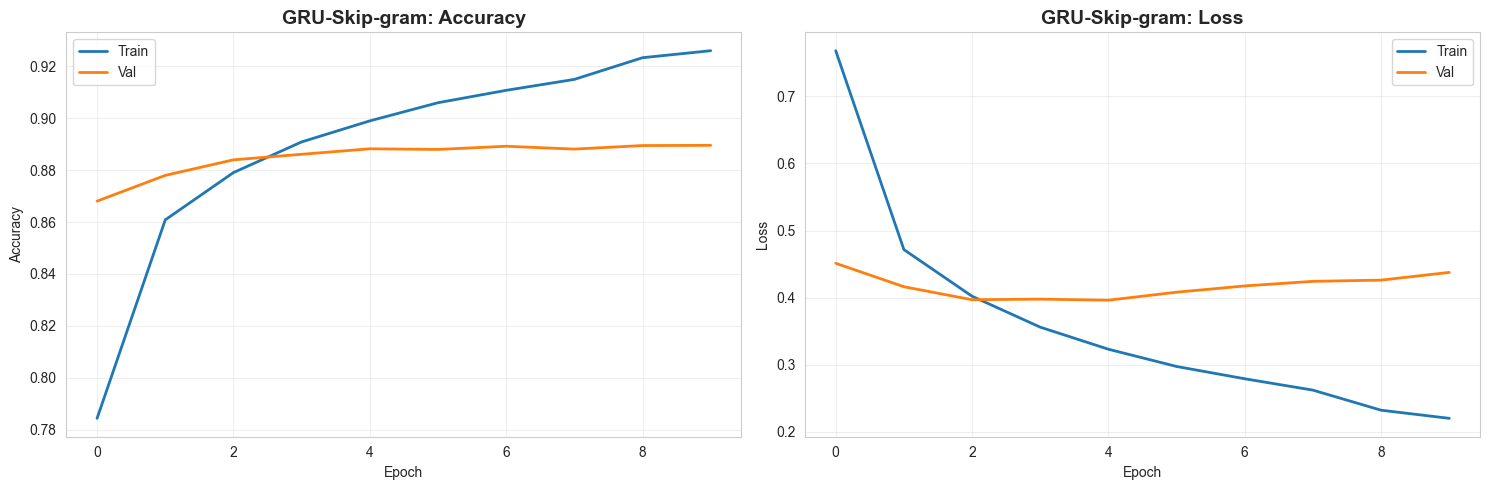

In [43]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_sg.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_sg.history['val_accuracy'], label='Val', linewidth=2)
axes[0].set_title('GRU-Skip-gram: Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_sg.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_sg.history['val_loss'], label='Val', linewidth=2)
axes[1].set_title('GRU-Skip-gram: Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_skipgram.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. GRU + CBOW Implementation

### 6.1 CBOW Training

**Approach:** CBOW predicts target words from context. Faster to train, better for frequent words.

**Research Context:** Mikolov et al. (2013) showed CBOW is faster but Skip-gram works better with rare words.

In [44]:
print("\n" + "="*60)
print("EXPERIMENT 3: GRU + CBOW (Word2Vec)")
print("="*60 + "\n")

print(" Training CBOW model...")

cbow_params = {
    'sentences': X_train_w2v_tokens,
    'vector_size': 200,
    'window': 5,
    'min_count': 2,
    'workers': 4,
    'sg': 0,  # CBOW mode
    'epochs': 20,
    'seed': RANDOM_SEED,
    'compute_loss': True
}

callback_cbow = Word2VecCallback()
cbow_model = Word2Vec(**cbow_params, callbacks=[callback_cbow])

print(f"\n✓ CBOW model trained")
print(f"✓ Vocabulary size: {len(cbow_model.wv):,}")
print(f"✓ Embedding dimension: {cbow_model.wv.vector_size}")

cbow_model.save('cbow_model.bin')
print("✓ Model saved")


EXPERIMENT 3: GRU + CBOW (Word2Vec)

 Training CBOW model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 5: Loss = 9,329,884


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 10: Loss = 15,730,794


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 15: Loss = 20,825,936


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Epoch 20: Loss = 25,249,894

✓ CBOW model trained
✓ Vocabulary size: 54,800
✓ Embedding dimension: 200
✓ Model saved


In [45]:
print("\n Testing CBOW embeddings:\n")

for word in test_words:
    if word in cbow_model.wv:
        similar = cbow_model.wv.most_similar(word, topn=5)
        print(f"{word:.<15} → {', '.join([w for w, _ in similar])}")
    else:
        print(f"{word:.<15} → [not in vocabulary]")


 Testing CBOW embeddings:

laptop......... → laptops, computer, notebook, ultrabook, mac
phone.......... → phones, cellphone, iphone, smartphone, kickstand
shoes.......... → shoe, boots, sandals, sneakers, loafers
dress.......... → dresses, dressy, lace, formal, prom
toy............ → toys, interactive, playset, plaything, toddlers


### 6.2 Sequence Preparation (CBOW)

In [46]:
print("\n Creating sequences for GRU...")

word2idx_cbow = {word: idx + 1 for idx, word in enumerate(cbow_model.wv.index_to_key)}
word2idx_cbow['<PAD>'] = 0
word2idx_cbow['<UNK>'] = len(word2idx_cbow)

vocab_size_cbow = len(word2idx_cbow)
print(f"✓ Vocabulary size: {vocab_size_cbow:,}")

X_train_seq_cbow = tokens_to_sequences(X_train_w2v_tokens, word2idx_cbow)
X_test_seq_cbow = tokens_to_sequences(X_test_w2v_tokens, word2idx_cbow)

max_len_cbow = max_len_sg

X_train_padded_cbow = pad_sequences(X_train_seq_cbow, maxlen=max_len_cbow, padding='post')
X_test_padded_cbow = pad_sequences(X_test_seq_cbow, maxlen=max_len_cbow, padding='post')

print(f"✓ Padded train shape: {X_train_padded_cbow.shape}")
print(f"✓ Padded test shape: {X_test_padded_cbow.shape}")


 Creating sequences for GRU...
✓ Vocabulary size: 54,802
✓ Padded train shape: (400000, 30)
✓ Padded test shape: (100000, 30)


In [47]:
print("\n Creating embedding matrix from CBOW...")

embedding_matrix_cbow = np.zeros((vocab_size_cbow, embedding_dim))

for word, idx in word2idx_cbow.items():
    if word in cbow_model.wv:
        embedding_matrix_cbow[idx] = cbow_model.wv[word]
    else:
        embedding_matrix_cbow[idx] = np.random.normal(0, 0.1, embedding_dim)

print(f"✓ Embedding matrix shape: {embedding_matrix_cbow.shape}")


 Creating embedding matrix from CBOW...
✓ Embedding matrix shape: (54802, 200)


### 6.3 Training and Evaluation (CBOW)

In [48]:
print("\n Training GRU-CBOW...")

# Use same architecture as Skip-gram for fair comparison
model_cbow = build_gru_word2vec_model(
    vocab_size=vocab_size_cbow,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix_cbow,
    max_len=max_len_cbow,
    num_classes=num_classes,
    trainable_embeddings=True
)

checkpoint_cbow = callbacks.ModelCheckpoint('best_model_cbow.h5', monitor='val_accuracy', save_best_only=True)
early_stop_cbow = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cbow = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_cbow = model_cbow.fit(
    X_train_padded_cbow,
    y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=[checkpoint_cbow, early_stop_cbow, reduce_lr_cbow],
    verbose=1
)

print("\n Training complete!")


 Training GRU-CBOW...
Epoch 1/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5452 - loss: 1.6927 - top5_acc: 0.7991

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 285s 104ms/step - accuracy: 0.6870 - loss: 1.1246 - top5_acc: 0.9037 - val_accuracy: 0.8373 - val_loss: 0.5744 - val_top5_acc: 0.9740 - learning_rate: 0.0010
Epoch 2/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7983 - loss: 0.7076 - top5_acc: 0.9618

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 273s 103ms/step - accuracy: 0.8072 - loss: 0.6748 - top5_acc: 0.9645 - val_accuracy: 0.8565 - val_loss: 0.4987 - val_top5_acc: 0.9802 - learning_rate: 0.0010
Epoch 3/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8280 - loss: 0.5926 - top5_acc: 0.9719

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 262s 98ms/step - accuracy: 0.8338 - loss: 0.5758 - top5_acc: 0.9733 - val_accuracy: 0.8674 - val_loss: 0.4606 - val_top5_acc: 0.9829 - learning_rate: 0.0010
Epoch 4/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8462 - loss: 0.5239 - top5_acc: 0.9781

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 266s 100ms/step - accuracy: 0.8503 - loss: 0.5110 - top5_acc: 0.9786 - val_accuracy: 0.8725 - val_loss: 0.4427 - val_top5_acc: 0.9845 - learning_rate: 0.0010
Epoch 5/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8604 - loss: 0.4735 - top5_acc: 0.9822

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 270s 102ms/step - accuracy: 0.8635 - loss: 0.4645 - top5_acc: 0.9824 - val_accuracy: 0.8762 - val_loss: 0.4321 - val_top5_acc: 0.9851 - learning_rate: 0.0010
Epoch 6/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8700 - loss: 0.4394 - top5_acc: 0.9842

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 276s 104ms/step - accuracy: 0.8723 - loss: 0.4315 - top5_acc: 0.9844 - val_accuracy: 0.8762 - val_loss: 0.4332 - val_top5_acc: 0.9850 - learning_rate: 0.0010
Epoch 7/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8762 - loss: 0.4122 - top5_acc: 0.9862

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 274s 103ms/step - accuracy: 0.8791 - loss: 0.4043 - top5_acc: 0.9866 - val_accuracy: 0.8772 - val_loss: 0.4405 - val_top5_acc: 0.9848 - learning_rate: 0.0010
Epoch 8/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 272s 102ms/step - accuracy: 0.8840 - loss: 0.3834 - top5_acc: 0.9876 - val_accuracy: 0.8770 - val_loss: 0.4465 - val_top5_acc: 0.9848 - learning_rate: 0.0010
Epoch 9/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8886 - loss: 0.3634 - top5_acc: 0.9890

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 271s 102ms/step - accuracy: 0.8917 - loss: 0.3551 - top5_acc: 0.9894 - val_accuracy: 0.8788 - val_loss: 0.4454 - val_top5_acc: 0.9851 - learning_rate: 5.0000e-04
Epoch 10/30
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8937 - loss: 0.3468 - top5_acc: 0.9899

2657/2657 ━━━━━━━━━━━━━━━━━━━━ 279s 105ms/step - accuracy: 0.8953 - loss: 0.3412 - top5_acc: 0.9901 - val_accuracy: 0.8800 - val_loss: 0.4506 - val_top5_acc: 0.9849 - learning_rate: 5.0000e-04

 Training complete!


In [49]:
print("\n Evaluating GRU-CBOW...")

test_results_cbow = model_cbow.evaluate(X_test_padded_cbow, y_test_cat, batch_size=128, verbose=1)

print("\n" + "="*60)
print("GRU-CBOW Test Results:")
print("="*60)
print(f"Test Loss: {test_results_cbow[0]:.4f}")
print(f"Test Accuracy: {test_results_cbow[1]:.4f}")
print(f"Test Top-5 Accuracy: {test_results_cbow[2]:.4f}")
print("="*60)


 Evaluating GRU-CBOW...
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8768 - loss: 0.4332 - top5_acc: 0.9845

GRU-CBOW Test Results:
Test Loss: 0.4332
Test Accuracy: 0.8768
Test Top-5 Accuracy: 0.9845


In [50]:
y_pred_cbow_proba = model_cbow.predict(X_test_padded_cbow, batch_size=128)
y_pred_cbow = np.argmax(y_pred_cbow_proba, axis=1)

print("\n Classification Report (GRU-CBOW):\n")
report_cbow = classification_report(
    y_test,
    y_pred_cbow,
    target_names=[label_to_category[i] for i in range(num_classes)],
    digits=4
)
print(report_cbow)

with open('classification_report_cbow.txt', 'w') as f:
    f.write(report_cbow)

782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step

 Classification Report (GRU-CBOW):

                                   precision    recall  f1-score   support

            Arts  Crafts Supplies     0.9178    0.9183    0.9180      1884
Audio/Video Receivers  Amplifiers     0.6456    0.8495    0.7336       937
         Automotive Tires  Wheels     0.9415    0.9540    0.9477      1890
      Automotive Tools  Equipment     0.0000    0.0000    0.0000         7
               Baby  Toddler Toys     0.8379    0.8671    0.8522      1061
                       Bath  Body     0.8329    0.8687    0.8504      3436
                Bathroom Hardware     0.8608    0.8843    0.8724      1728
                           Beauty     0.7800    0.5000    0.6094      3736
        Beauty Tools  Accessories     0.8156    0.9093    0.8599      3264
                          Bedding     0.0000    0.0000    0.0000         3
      Building  Construction Toys     0.9674    0.9423    0.9547      1856
                Bui

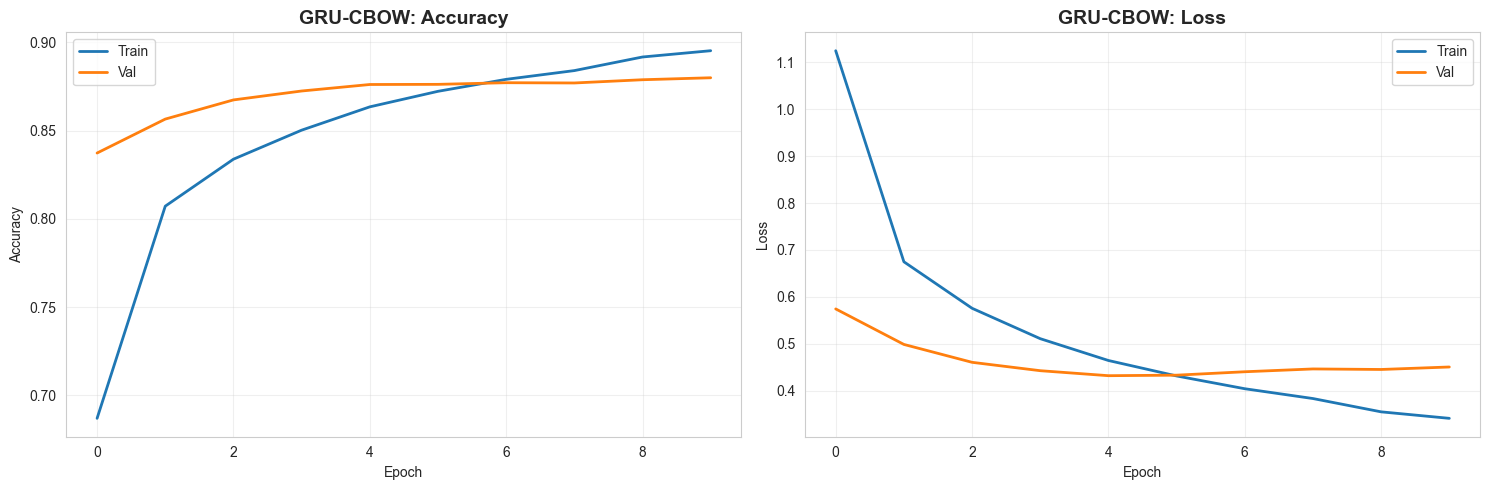

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_cbow.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history_cbow.history['val_accuracy'], label='Val', linewidth=2)
axes[0].set_title('GRU-CBOW: Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_cbow.history['loss'], label='Train', linewidth=2)
axes[1].plot(history_cbow.history['val_loss'], label='Val', linewidth=2)
axes[1].set_title('GRU-CBOW: Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_cbow.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Comparative Analysis

Comprehensive comparison across all three embedding techniques.

In [52]:
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: GRU with Different Embeddings")
print("="*80 + "\n")

# Compile results
results_comparison = pd.DataFrame({
    'Embedding': ['TF-IDF', 'Skip-gram', 'CBOW'],
    'Test Accuracy': [
        test_results_tfidf[1],
        test_results_sg[1],
        test_results_cbow[1]
    ],
    'Test Loss': [
        test_results_tfidf[0],
        test_results_sg[0],
        test_results_cbow[0]
    ],
    'Top-5 Accuracy': [
        test_results_tfidf[2],
        test_results_sg[2],
        test_results_cbow[2]
    ]
})

print("\n Performance Comparison:\n")
print(results_comparison.to_string(index=False))
print("\n")

results_comparison.to_csv('model_comparison_results.csv', index=False)
print("✓ Results saved to 'model_comparison_results.csv'")


COMPARATIVE ANALYSIS: GRU with Different Embeddings


 Performance Comparison:

Embedding  Test Accuracy  Test Loss  Top-5 Accuracy
   TF-IDF        0.81511   0.659371         0.95691
Skip-gram        0.88830   0.398235         0.98730
     CBOW        0.87678   0.433159         0.98449


✓ Results saved to 'model_comparison_results.csv'


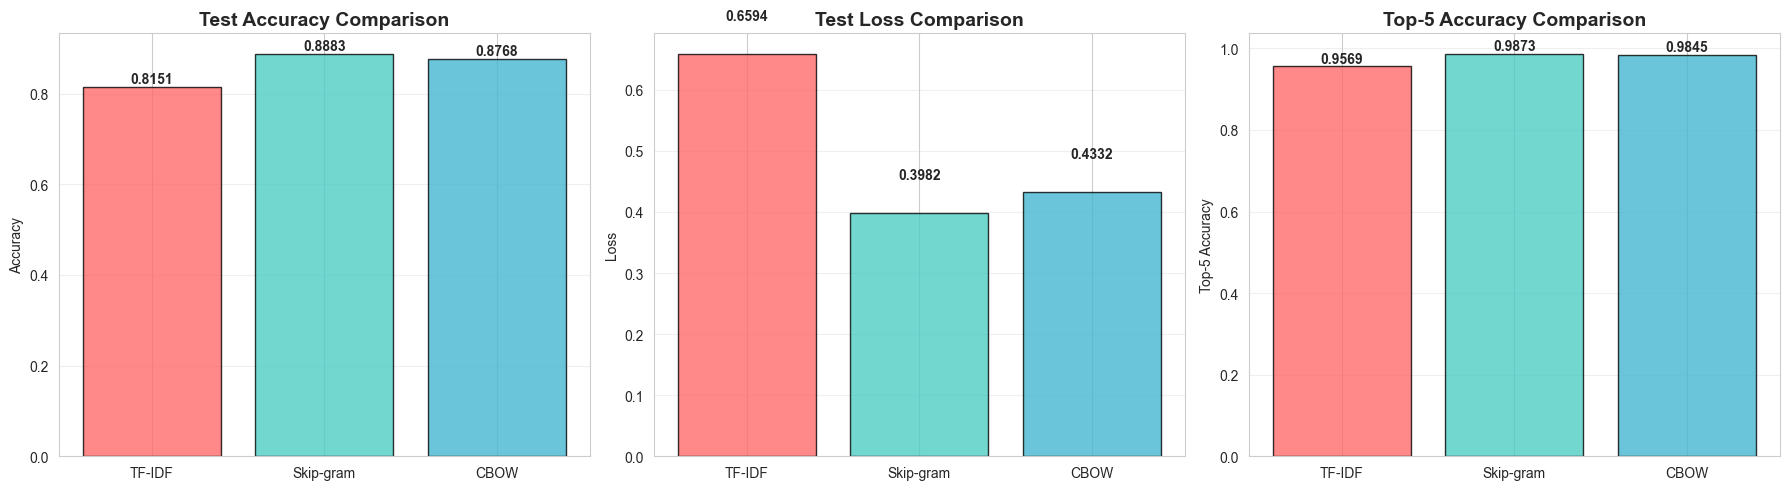

✓ Comparison visualization saved


In [53]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].bar(results_comparison['Embedding'], results_comparison['Test Accuracy'], 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_comparison['Test Accuracy']):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Loss
axes[1].bar(results_comparison['Embedding'], results_comparison['Test Loss'],
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_comparison['Test Loss']):
    axes[1].text(i, v + 0.05, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Top-5 Accuracy
axes[2].bar(results_comparison['Embedding'], results_comparison['Top-5 Accuracy'],
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8, edgecolor='black')
axes[2].set_title('Top-5 Accuracy Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Top-5 Accuracy')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_comparison['Top-5 Accuracy']):
    axes[2].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison visualization saved")